In [1194]:
import pandas as pd
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re

In [1195]:
df_user = pd.read_csv('takehome_users.csv',encoding='latin-1', index_col='object_id')

In [1196]:
df = pd.read_csv('takehome_user_engagement.csv')

In [1197]:
df_user.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [1198]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_time               12000 non-null  object 
 1   name                        12000 non-null  object 
 2   email                       12000 non-null  object 
 3   creation_source             12000 non-null  object 
 4   last_session_creation_time  8823 non-null   float64
 5   opted_in_to_mailing_list    12000 non-null  int64  
 6   enabled_for_marketing_drip  12000 non-null  int64  
 7   org_id                      12000 non-null  int64  
 8   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(3), object(4)
memory usage: 937.5+ KB


In [1199]:
df['user_id'].value_counts()

3623     606
906      600
1811     593
7590     590
8068     585
        ... 
4699       1
4698       1
4697       1
4696       1
12000      1
Name: user_id, Length: 8823, dtype: int64

In [1200]:
# there are total 8823 users

In [1201]:
#get adopted users

In [1202]:
df['date'] = pd.to_datetime(df['time_stamp']).dt.date.sort_values()

In [1203]:
def get_days(df):
    df.drop_duplicates(subset='date')
    days = df['date'].diff(periods=2)
    return (any(days<=timedelta(days=7))*1)

In [1204]:
users = df.groupby('user_id').apply(get_days)

In [1205]:
users

user_id
1        0
2        1
3        0
4        0
5        0
        ..
11996    0
11997    0
11998    0
11999    0
12000    0
Length: 8823, dtype: int64

In [1206]:
#name the series to merge it with dataframe
users.name = 'adopted_user'

In [1207]:
users.sum(), len(users)

(1656, 8823)

In [1208]:
# there are 16556 adopted users

In [1209]:
# df_user

In [1210]:
df_user = pd.concat([df_user, users], join='inner', axis=1)

In [1211]:
df_user.isnull().sum()

creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
adopted_user                     0
dtype: int64

In [1212]:
# Replace null values with 0

In [1213]:
df_user['invited_by_user_id'].fillna(0, inplace=True)

In [1214]:
#lets check domain of the email 
df_user['domain'] = df_user['email'].apply(lambda x : x.split('@')[1])

In [1215]:
df_user.drop(['name','email'],axis=1, inplace=True)

In [1216]:
df_user['creation_time'] = pd.to_datetime(df_user['creation_time'])
# pd.to_datetime(df_user['last_session_creation_time'], unit='s')


In [1217]:
df_user['last_session_creation_time'] = df_user['last_session_creation_time'].apply(lambda x : datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [1218]:
df_user['last_session_creation_time'] = pd.to_datetime(df_user['last_session_creation_time'])
df_user['last_session_creation_time']

1       2014-04-21 20:53:30
2       2014-03-30 20:45:04
3       2013-03-19 16:14:52
4       2013-05-22 01:09:28
5       2013-01-22 02:14:20
                ...        
11996   2013-09-05 23:14:15
11997   2013-01-15 10:28:37
11998   2014-04-27 05:45:16
11999   2012-06-02 04:55:59
12000   2014-01-26 00:57:12
Name: last_session_creation_time, Length: 8823, dtype: datetime64[ns]

In [1219]:
df_user['total_login_time'] = (df_user['last_session_creation_time']-df_user['creation_time']).dt.days

In [1220]:
df_user['total_login_time'] = np.where(df_user['total_login_time']<0,0,df_user['total_login_time'])

In [1221]:
df_user.drop(['creation_time','last_session_creation_time'], axis=1,inplace=True)

In [1222]:
df_user

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,domain,total_login_time
1,GUEST_INVITE,1,0,11,10803.0,0,yahoo.com,0
2,ORG_INVITE,0,0,1,316.0,1,gustr.com,135
3,ORG_INVITE,0,0,94,1525.0,0,gustr.com,0
4,GUEST_INVITE,0,0,1,5151.0,0,yahoo.com,0
5,GUEST_INVITE,0,0,193,5240.0,0,yahoo.com,4
...,...,...,...,...,...,...,...,...
11996,ORG_INVITE,0,0,89,8263.0,0,gustr.com,0
11997,SIGNUP_GOOGLE_AUTH,0,0,200,0.0,0,gmail.com,4
11998,GUEST_INVITE,1,1,83,8074.0,0,cuvox.de,0
11999,PERSONAL_PROJECTS,0,0,6,0.0,0,iuxiw.com,1


In [1223]:
# EDA

In [1224]:
df_user.groupby('opted_in_to_mailing_list')['adopted_user'].apply(lambda x : sum(x)/len(x))


opted_in_to_mailing_list
0    0.185994
1    0.192722
Name: adopted_user, dtype: float64

In [1225]:
#there are 18% of adopted users with not opted for mailing list and 19% opted for mailing list

In [1226]:
#plot correlation of different features with "adopted_user"

In [1227]:
def count_plot(col):
    sns.countplot(data=df_user, x=col, hue='adopted_user')
    plt.xticks(rotation=90);

In [1228]:
#get only the domain of email id

In [1229]:
top_emails = df_user['domain'].value_counts()[:6].index
top_emails

Index(['gmail.com', 'yahoo.com', 'jourrapide.com', 'gustr.com', 'cuvox.de',
       'hotmail.com'],
      dtype='object')

In [1230]:
#lets convert others email id to 'others' than top 6 

In [1231]:
df_user['domain']= [x  if x in top_emails else 'others' for x in df_user['domain']]

In [1232]:
df_user['domain'].value_counts()

gmail.com         2930
yahoo.com         1726
jourrapide.com     883
gustr.com          842
cuvox.de           828
others             811
hotmail.com        803
Name: domain, dtype: int64

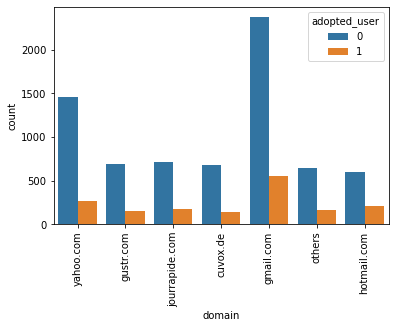

In [1233]:
# domain and adopted user
count_plot('domain')

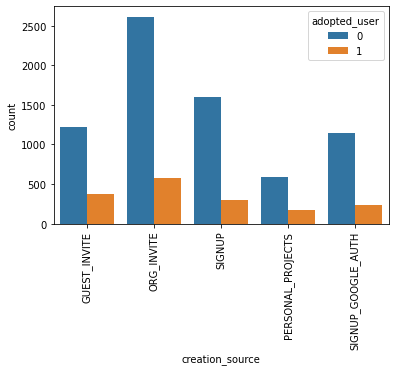

In [1234]:
# Creation source and adopted user
count_plot('creation_source')

In [1235]:
# Percentage of adopted users users who are invited by other users and who signed up for personal projects

In [1236]:
df_user[df_user['adopted_user']==1].groupby('creation_source')['adopted_user'].count()/len(df_user[df_user['adopted_user']==1])

creation_source
GUEST_INVITE          0.222826
ORG_INVITE            0.346618
PERSONAL_PROJECTS     0.103865
SIGNUP                0.182367
SIGNUP_GOOGLE_AUTH    0.144324
Name: adopted_user, dtype: float64

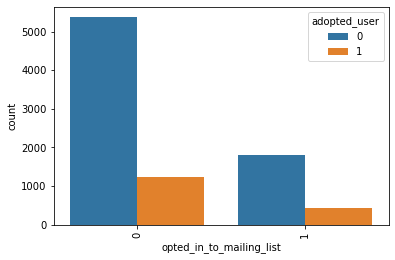

In [1237]:
count_plot('opted_in_to_mailing_list')

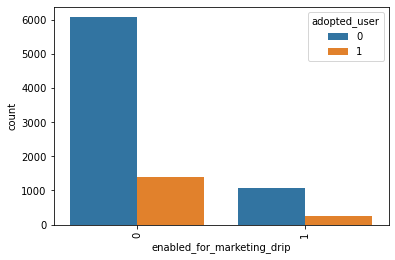

In [1238]:
count_plot('enabled_for_marketing_drip')


In [1239]:
df_user['invited_by_user_id'].value_counts()

0.0        4047
4612.0       10
11770.0       9
2308.0        9
730.0         8
           ... 
6455.0        1
3689.0        1
1255.0        1
6420.0        1
5093.0        1
Name: invited_by_user_id, Length: 2230, dtype: int64

In [1240]:
df_user['org_id'].value_counts()

0      228
1      172
2      150
3      125
4      122
      ... 
396      6
400      6
397      5
386      4
416      2
Name: org_id, Length: 417, dtype: int64

In [1241]:
# users
# user_login = pd.concat([pd.DataFrame(df_user['total_login_time'].value_counts()),users], axis=1, join='inner')
# user_login

In [1242]:
#lets plot login_time for adopted and not adopted users

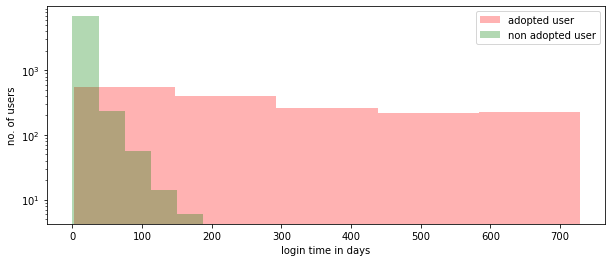

In [1243]:
plt.figure(figsize=(10,4))
flt = df_user['adopted_user']==1
plt.hist(df_user.loc[flt]['total_login_time'],alpha=0.3, bins=5, color='r',label='adopted user')
flt = df_user['adopted_user']==0
plt.hist(df_user.loc[flt]['total_login_time'],alpha=0.3, bins=5, color='g',label='non adopted user')
plt.yscale('log')
plt.xlabel('login time in days')
plt.ylabel('no. of users')
plt.legend()

In [1244]:
df_user.corr()['adopted_user'].sort_values(ascending=False)

adopted_user                  1.000000
total_login_time              0.777457
org_id                        0.077748
invited_by_user_id            0.020247
opted_in_to_mailing_list      0.007485
enabled_for_marketing_drip    0.004290
Name: adopted_user, dtype: float64

In [1245]:
#its clear that column 'total_login_time' is highly correlated with 'adopted_user' almost 77%

<AxesSubplot:>

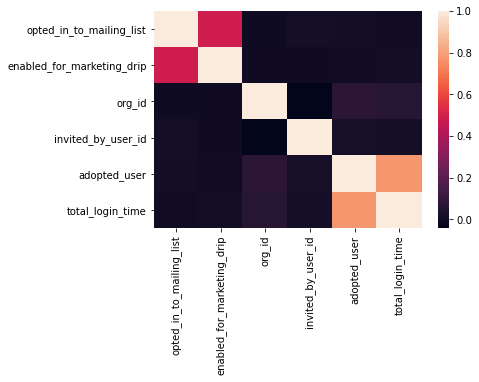

In [1246]:
sns.heatmap(df_user.corr())

In [1247]:
df_user = pd.get_dummies(df_user)

In [1248]:
# df_user['GUEST_INVITE']

In [1249]:
X= df_user.drop('adopted_user',axis=1)

In [1250]:
y=df_user['adopted_user']

In [1251]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

In [1252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [1253]:
#list for models and accuracy
list_model = ['Logistic Regression', 'Random Forest', 'KNN','Gradient Boosting']
list_acc = []
list_pr = []
list_recall = []

# Logistic Regression 

In [1254]:
lr = LogisticRegression()

In [1044]:
param_grid = {'penalty' : ['l2'],
              'C' : [0.5,1.0],
              'solver':['lbfgs'],
              'max_iter':[100,200,500]
             }


In [1045]:
gd = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5)

In [1046]:
gd.fit(X_train,y_train)

/Users/shaliniantil/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/shaliniantil/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.5, 1.0], 'max_iter': [100, 110, 120],
                         'penalty': ['l2'], 'solver': ['lbfgs']})

In [1047]:
gd.best_params_

{'C': 0.5, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

In [ ]:
#model with best params

In [1255]:
lr = LogisticRegression(penalty='l2',C=1.0)

In [1256]:
lr.fit(X_train,y_train)

LogisticRegression()

In [1257]:
y_pred = lr.predict(X_test)

In [1258]:
# accuracy_score(y_test,y_pred)

In [1259]:
list_acc.append(accuracy_score(y_test, y_pred)),
list_pr.append(precision_score(y_test,y_pred)),
list_recall.append(recall_score(y_test,y_pred))

# Random Forest

In [1061]:
#tune parameters for RandomForest
param_grid = { 'n_estimators':[50],
    'criterion':['gini'],
    'max_depth':[None,2,3,],
    'min_samples_split':[2,3,],
    'min_samples_leaf':[1,2],
    'max_features':['sqrt'],
    'bootstrap':[True],
    'random_state':[42],
    'max_samples':[None,.50,.75],
    'ccp_alpha':[0.0,0.1]
           }

In [1062]:
rf = RandomForestClassifier()

In [1063]:
gd = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

In [1064]:
gd.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'ccp_alpha': [0.0, 0.1],
                         'criterion': ['gini'], 'max_depth': [None, 2, 3],
                         'max_features': ['sqrt'],
                         'max_samples': [None, 0.5, 0.75],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3], 'n_estimators': [50],
                         'random_state': [42]})

In [1065]:
gd.best_params_

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_samples': 0.5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50,
 'random_state': 42}

In [1260]:
#final model with best params
rf = RandomForestClassifier(bootstrap= True,
 criterion='gini',
 ccp_alpha= 0.0,
 max_depth= None,
 max_features='sqrt',
 max_leaf_nodes= None,
 max_samples=0.5,
 min_samples_leaf=2,
 min_samples_split=2,
 n_estimators=50,
 random_state=42)

In [1261]:
rf.fit(X_train,y_train)

RandomForestClassifier(max_samples=0.5, min_samples_leaf=2, n_estimators=50,
                       random_state=42)

In [1262]:
y_pred = rf.predict(X_test)

In [1263]:
# accuracy_score(y_test,y_pred)

In [1264]:
list_acc.append(accuracy_score(y_test, y_pred)),
list_pr.append(precision_score(y_test,y_pred)),
list_recall.append(recall_score(y_test,y_pred))

In [1265]:
#graph feature importances

<AxesSubplot:>

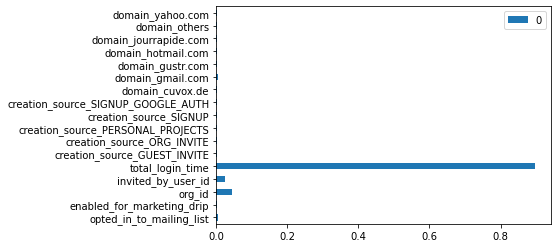

In [1266]:
pd.DataFrame(rf.feature_importances_, index=X_train.columns).plot(kind='barh')

# KNN Clasifier

In [1075]:
knn = KNeighborsClassifier()

In [1076]:
param_grid = {'n_neighbors': np.arange(1,10)}

In [1077]:
gd = GridSearchCV(estimator=knn,param_grid = param_grid, cv=5)

In [1079]:
gd.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [1080]:
y_pred = gd.predict(X_test)

In [1081]:
gd.best_params_

{'n_neighbors': 3}

In [1267]:
#final model with best params
knn = KNeighborsClassifier(n_neighbors=3)

In [1268]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [1269]:
y_pred= knn.predict(X_test)

/Users/shaliniantil/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


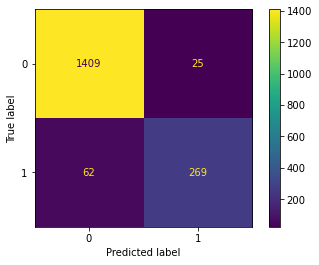

In [1270]:
plot_confusion_matrix(knn,X_test,y_test)

In [1271]:
# precision_score(y_test,y_pred), recall_score(y_test,y_pred)

In [1272]:
list_acc.append(accuracy_score(y_test, y_pred)),
list_pr.append(precision_score(y_test,y_pred)),
list_recall.append(recall_score(y_test,y_pred))

# GradientBoostingClassifier

In [1273]:
gbs = GradientBoostingClassifier()

In [1093]:
param_grid = {
    'learning_rate':[0.1,0.2],
    'n_estimators':[50],
    'max_depth':[3,4],
    'max_features':[None,],
    'ccp_alpha':[0.0,0.1]
}

In [1094]:
gd = GridSearchCV(estimator=gbs,param_grid = param_grid)

In [1095]:
gd.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'ccp_alpha': [0.0, 0.1], 'learning_rate': [0.1, 0.2],
                         'max_depth': [3, 4], 'max_features': [None],
                         'n_estimators': [50]})

In [1096]:
gd.best_params_

{'ccp_alpha': 0.0,
 'learning_rate': 0.2,
 'max_depth': 3,
 'max_features': None,
 'n_estimators': 50}

In [1274]:
#final GDboost model
gbs = GradientBoostingClassifier(ccp_alpha= 0.0,
 learning_rate= 0.2,
 max_depth= 3,
 max_features= None,
 n_estimators= 50,
 random_state=42)

In [1275]:
gbs.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, n_estimators=50, random_state=42)

In [1276]:
y_pred = gbs.predict(X_test)

In [1277]:
# precision_score(y_test,y_pred), recall_score(y_test,y_pred)

In [1278]:
list_acc.append(accuracy_score(y_test, y_pred)),
list_pr.append(precision_score(y_test,y_pred)),
list_recall.append(recall_score(y_test,y_pred))

# Feature importances

In [1279]:
gbs.feature_importances_

array([3.81970435e-05, 4.72192457e-05, 6.84638850e-03, 5.17017871e-03,
       9.85562359e-01, 0.00000000e+00, 2.36655413e-04, 4.85586893e-04,
       2.50343462e-04, 5.64110094e-05, 9.64514304e-06, 1.55589756e-04,
       5.43462092e-04, 0.00000000e+00, 5.06784533e-04, 6.64895082e-05,
       2.46899102e-05])

<AxesSubplot:>

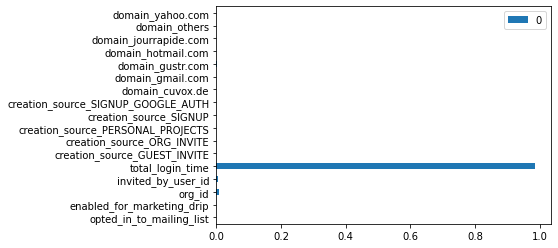

In [1280]:
pd.DataFrame(gbs.feature_importances_, index=X_train.columns).plot(kind='barh')

In [1281]:
pd.DataFrame(zip(list_model,list_acc,list_pr,list_recall), columns=['Model','accuracy score','precison score','recall_score']).set_index('Model')


,accuracy score,precison score,recall_score
Model,,,
Logistic Regression,0.961473,0.925566,0.864048
Random Forest,0.960340,0.914286,0.870091
KNN,0.950708,0.914966,0.812689
Gradient Boosting,0.956941,0.902208,0.864048


In [ ]:
# Steps Involved in Classification in Scikit-Learn
# Preprocess Data
# feature engineering
# correlation between features
# Create Train and Test Sets
# Instantiate the model/estimator
# Specify Hyperparameter Space
# Instantiate GridSearchCV object
# Fit model with best params
# Predict on the Test Set
# Compute Scores for the Model
# Compute feature importances

# Models:
# Logistic Regression 
# Random Forest
# K-Nearest Neighbor 
# Gradient Boosting

In [ ]:
# As expected after computing correlation matrix ,both the gradient boosting and random forest model's 
# most important feature is total_login_time in prediction  
# Based on this, an effective way of growing adopted users might be encouraging existing users to 
# log in and use the software after they signed up for the account